In [1]:
# 1. データを準備する

In [46]:
from __future__ import print_function
import matplotlib.pyplot as plt
from chainer.datasets import mnist

# Download the MNIST data if you haven't downloaded it yet
train, test = mnist.get_mnist(withlabel=True, ndim=1)

# Display an example from the MNIST dataset.
# `x` contains the inpu t image array and `t` contains that target class
# label as an integer.
x, t = train[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.savefig('5.png')


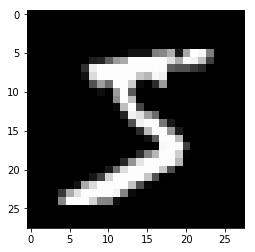

数字: 5


In [47]:
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('数字:', t)

In [40]:
# 2. データイテレータをつくります。

In [14]:
from chainer import iterators

# バッチサイズを選択
batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize,
                                     repeat=False, shuffle=False)

In [16]:
# 3. モデルを定義する

In [20]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Chain, Variable, optimizers
from chainer import report, training

In [21]:
class MyNetwork(Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MyNetwork, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_mid_units)
            self.l3 = L.Linear(n_mid_units, n_out)

    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        return self.l3(h)

model = MyNetwork()

In [22]:
# 4. アルゴリズム選択
# optimizers.MomentumSGD

In [23]:
from chainer import optimizers

# Choose an optimizer algorithm
optimizer = optimizers.MomentumSGD(lr=0.01, momentum=0.9)

# Give the optimizer a reference to the model so that it
# can locate the model's parameters.
optimizer.setup(model)

In [25]:
# 5. 訓練ループ

In [27]:
import numpy as np
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu

max_epoch = 10

while train_iter.epoch < max_epoch:

    # ---------- One iteration of the training loop ----------
    train_batch = train_iter.next()
    image_train, target_train = concat_examples(train_batch)

    # Calculate the prediction of the network
    prediction_train = model(image_train)

    # Calculate the loss with softmax_cross_entropy
    loss = F.softmax_cross_entropy(prediction_train, target_train)

    # Calculate the gradients in the network
    model.cleargrads()
    loss.backward()

    # Update all the trainable paremters
    optimizer.update()
    # --------------------- until here ---------------------

    # Check the validation accuracy of prediction after every epoch
    if train_iter.is_new_epoch:  # If this iteration is the final iteration of the current epoch

        # Display the training loss
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(to_cpu(loss.data))), end='')

        test_losses = []
        test_accuracies = []
        while True:
            test_batch = test_iter.next()
            image_test, target_test = concat_examples(test_batch)

            # Forward the test data
            prediction_test = model(image_test)

            # Calculate the loss
            loss_test = F.softmax_cross_entropy(prediction_test, target_test)
            test_losses.append(to_cpu(loss_test.data))

            # Calculate the accuracy
            accuracy = F.accuracy(prediction_test, target_test)
            accuracy.to_cpu()
            test_accuracies.append(accuracy.data)

            if test_iter.is_new_epoch:
                test_iter.epoch = 0
                test_iter.current_position = 0
                test_iter.is_new_epoch = False
                test_iter._pushed_position = None
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(test_losses), np.mean(test_accuracies)))

epoch:01 train_loss:0.3011 val_loss:0.2790 val_accuracy:0.9178
epoch:02 train_loss:0.2119 val_loss:0.1941 val_accuracy:0.9430
epoch:03 train_loss:0.2214 val_loss:0.1610 val_accuracy:0.9524
epoch:04 train_loss:0.2570 val_loss:0.1347 val_accuracy:0.9587
epoch:05 train_loss:0.1515 val_loss:0.1217 val_accuracy:0.9644
epoch:06 train_loss:0.0890 val_loss:0.1026 val_accuracy:0.9697
epoch:07 train_loss:0.0630 val_loss:0.1013 val_accuracy:0.9688
epoch:08 train_loss:0.0420 val_loss:0.0882 val_accuracy:0.9719
epoch:09 train_loss:0.0150 val_loss:0.0906 val_accuracy:0.9718
epoch:10 train_loss:0.0607 val_loss:0.0802 val_accuracy:0.9746


In [29]:
# モデルを保存
from chainer import serializers
serializers.save_npz('my_mnist.model', model)

In [36]:
# Create an instance of the network you trained
model = MyNetwork()

# モデルをロード
serializers.load_npz('my_mnist.model', model)

# Get a test image and label
x, t = test[0]
plt.savefig('7.png')

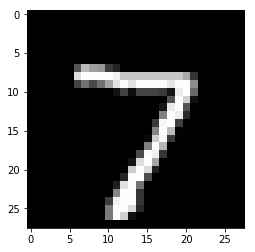

label: 7


In [38]:
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

In [44]:
# Change the shape of the minibatch.
# In this example, the size of minibatch is 1.
# Inference using any mini-batch size can be performed.

print(x.shape, end=' -> ')
x = x[None, ...]
print(x.shape)

# forward calculation of the model by sending X
y = model(x)

# The result is given as Variable, then we can take a look at the contents by the attribute, .data.
y = y.data

# Look up the most probable digit number using argmax
pred_label = y.argmax(axis=1)

print('予測値:', pred_label[0])

(1, 784) -> (1, 1, 784)
予測値: 7
